<a href="https://colab.research.google.com/github/willjhliang/traffic-sign-recognition/blob/main/Submission_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition Model Walk-Through
This notebook will provide an example of how we visualized and processed our dataset, along with how we trained and evaluated a Convolutional Neural Network classifier.

**Content Creators:** Yifei (Freddy) Liu, William Liang, Vincent Cai

## Setup
Import relevant libraries and load in dataset

In [1]:
# Download dataset from github repo
!git clone --quiet https://github.com/willjhliang/traffic-sign-recognition.git
!mv traffic-sign-recognition/* .
!rm -r traffic-sign-recognition

In [21]:
# Imports
from copy import deepcopy
import itertools

import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import itertools
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (4, 2.5)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tabulate import tabulate
import seaborn as sns


import torch
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils import data
import torchvision

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)


We also define some constants that we will use throughout this notebook

In [8]:
# Define Constants:
K = 36 # Number of total classes
S = 32 # Size of image, dimension is (S, S, 3)
class_size = 320 # Number of images per class
validation_ratio = 0.1 # Proportion of training data to set aside for validation
random_seed = 19104 # Seed all random operations to ensure reproducability
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

## Dataset

Below are methods that we use to pre-process our given dataset

In [6]:
def load_data(datapath):
    """Loads images from files and performs basic pre-processing."""
    data = {}
    for k in range(K):
        data[k] = []

    for f in os.listdir(datapath):
        k = int(f[:3])  # Get label from filename
        img = Image.open(os.path.join(datapath, f)).convert('RGB')
        img = np.asarray(img) / 255  # Set pixel values to [0, 1]
        if len(data[k]) < class_size:
            data[k].append(img)
    for k in range(K):
        random.shuffle(data[k])
    
    return data

def consolidate_data(data):
    """Converts image-label data from map to numpy arrays."""
    X = []
    y = []
    for k in range(K):
        for i in data[k]:
            i = cv2.resize(i, (S, S))
            X.append(np.swapaxes(i, 0, -1))
            y.append(k)
    X = np.array(X)
    y = np.array(y)
    
    shuffled_indices = np.random.permutation(len(X))
    X = X[shuffled_indices]
    y = y[shuffled_indices]
    X_flattened = np.reshape(X, (X.shape[0], -1))
    
    return X, X_flattened, y

def split_validation(X_train, y_train):
    """Splits training data into train and validation sets. Used in models below."""
    val_split = int(X_train.shape[0] * validation_ratio)
    X_train, X_val = X_train[val_split:], X_train[:val_split]
    y_train, y_val = y_train[val_split:], y_train[:val_split]
    return X_train, X_val, y_train, y_val

def visualize_data(train_data):
    """Visualizes the first image in each class."""
    _, axs = plt.subplots(4, 10, figsize=(10, 3))
    for k, (i, j) in itertools.zip_longest(range(K), list(itertools.product(range(4), range(10))), fillvalue=-1):
        axs[i, j].axis('off')
        if k >= 0:
            axs[i,j].imshow(train_data[k][0])


def compare_class_dist(data_1, data_2):
    """Compares the class distribution of two datasets."""
    class_dist_1 = [len(data_1[k]) for k in range(K)]
    class_dist_2 = [len(data_2[k]) for k in range(K)]

    _, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    axs[0].bar(list(range(K)), class_dist_1)
    axs[1].bar(list(range(K)), class_dist_2);



First, load in both the training and testing datasets

In [9]:
train_data = load_data('data/filtered_images/train')
test_data = load_data('data/filtered_images/test')
labels = pd.read_csv("data/filtered_labels.csv")

Run the cell below to look at the first image within each of the 36 classes.
This also shows the class distributions for both the training and test datasets

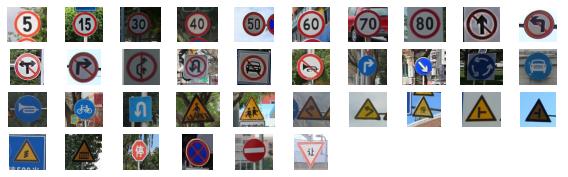

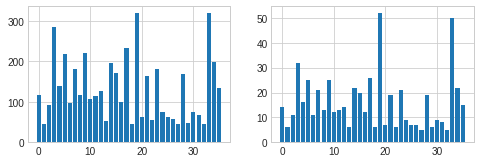

In [10]:
visualize_data(train_data)
compare_class_dist(train_data, test_data)

Looks like there is a significant amount of class imbalance here. We will use image augmentation techniques to generate more training images to reduce the imbalance

## Pre-Processing
Define augmentation methods below

In [11]:
def center_crop(img, center_percentage):
    """Crops out edges of an image, leaving the center."""
    width, height, _ = img.shape
    width_offset = int(width * (1 - center_percentage) / 2)
    height_offset = int(height * (1 - center_percentage) / 2)
    img = img[width_offset:width-width_offset, height_offset:height-height_offset]
    return img


def rotate_img(img, angle):
    """Rotates an image and replaces empty space with black."""
    height, width, _ = img.shape
    center_x, center_y = (width // 2, height // 2)

    rot_mat = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])

    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    rot_mat[0, 2] += (new_width / 2) - center_x
    rot_mat[1, 2] += (new_height / 2) - center_y

    img = cv2.warpAffine(img, rot_mat, (new_width, new_height))
    img = cv2.resize(img, (width, height))

    return img


def shift_brightness(img, shift):
    """Adjusts brightness of all pixels in image."""
    img = np.clip(img + shift, 0, 1)
    return img


def augment_img(img):
    """Augments image with rotation, cropping, and brightness shifts."""
    rot_angle = random.randint(-20, 20)
    crop_center_percentage = random.randint(70, 90) / 100
    crop_center_percentage = 0.8
    brightness_shift = random.randint(-10, 10) / 100

    img = rotate_img(img, rot_angle)
    # img = center_crop(img, crop_center_percentage)
    # img = shift_brightness(img, brightness_shift)
    img = center_crop(img, 0.8)

    return img


def augment_dataset(train_data):
    """Applies augmentation to all classes in dataset."""
    max_k_size = max([len(train_data[k]) for k in range(len(train_data))])
    for k in range(len(train_data)):
        k_size = len(train_data[k])
        for i in range(max_k_size - k_size):  # Add augmented images until we have class_size images
            train_data[k].append(augment_img(train_data[k][i % k_size]))
    return train_data


def visualize_augmentation(train_data):
    """Visualizes the augmentation applied onto the last image in each class."""
    fig, axs = plt.subplots(4, 10, figsize=(15, 5))
    for k, (i, j) in itertools.zip_longest(range(len(train_data)), list(itertools.product(range(4), range(10))), fillvalue=-1):
        axs[i,j].axis('off')
        if k >= 0:
            img = augment_img(train_data[k][-1])
            axs[i,j].imshow(augment_img(img))
    plt.show()

Now run the cell below to augment the data.
We can compare the class distributions of our original training dataset and our new training dataset after the image augmentations. There is a much more even class distribution now

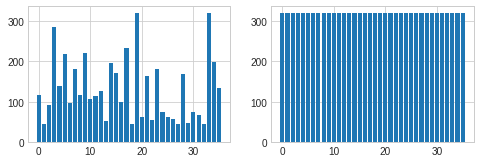

In [12]:
original_train_data = deepcopy(train_data)
train_data = augment_dataset(train_data)
compare_class_dist(original_train_data, train_data)

Create X_train and y_train datasets to pass into the classifiers

In [13]:
X_train, X_train_flattened, y_train = consolidate_data(train_data)
X_test, X_test_flattened, y_test = consolidate_data(test_data)

print(f'X_train shape: {X_train.shape}')
print(f'X_train_flattened shape: {X_train_flattened.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (11520, 3, 32, 32)
X_train_flattened shape: (11520, 3072)
X_test shape: (572, 3, 32, 32)


### Dimensionality Reduction
Currently, our datasets are very large considering each image has 3072 pixels/features. We will reduce the dimensions by performing PCA on the images

PCA helper functions defined below

In [14]:
def run_pca(X_train_flattened, X_test_flattened):
    """Runs PCA on training and test data, visualizing the variance explained by each component."""
    covar_matrix = PCA(n_components=min(X_train_flattened.shape[0], 32*32))
    covar_matrix.fit(X_train_flattened)
    var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
    plt.plot(var[:300]);

    pca = PCA(n_components=150)
    pca.fit(X_train_flattened)
    X_train_pca = pca.transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)
    return X_train_pca, X_test_pca, pca


def visualize_pca(pca):
    """Visualizes first 24 principal components."""
    fig, axes = plt.subplots(3, 8, figsize=(9, 3.5),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )
    
    for i, ax in enumerate(axes.flat):
        img = pca.components_[i].reshape(3, 32, 32)
        min_val, max_val = np.min(img), np.max(img)
        img = (img - min_val) / (max_val - min_val)
        img = np.swapaxes(img, 0, -1)
        ax.imshow(img)
    plt.show()


def visualize_pca_per_channel(X_train):
    """Visualizes first 24 principal components for each channel."""
    def pca_on_channel(channel):
        X_train_channel = np.array([i.flatten() for i in X_train[:, channel, :, :]])
        ret = PCA(n_components=150)
        ret.fit(X_train_channel)
        return ret

    fig, axes = plt.subplots(3, 8, figsize=(9, 4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )
    for i, ax in enumerate(axes.flat):
        ax.imshow(pca_on_channel(0).components_[i].reshape(32, 32))
    
    fig, axes = plt.subplots(3, 8, figsize=(9, 4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )
    for i, ax in enumerate(axes.flat):
        ax.imshow(pca_on_channel(1).components_[i].reshape(32, 32))
        
    fig, axes = plt.subplots(3, 8, figsize=(9, 4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )
    for i, ax in enumerate(axes.flat):
        ax.imshow(pca_on_channel(2).components_[i].reshape(32, 32))


def visualize_image_components(pca, image):
   fig, axes = plt.subplots(1, 8, figsize=(9, 3),
       subplot_kw={'xticks':[], 'yticks':[]},
       gridspec_kw=dict(hspace=0.1, wspace=0.1)
   )
  
   ns = [0, 1, 2, 10, 30, 50, 100, 150]
   for i, ax in enumerate(axes.flat):
       if i >= len(ns): break
       img = pca.components_[:ns[i] + 1] @ image @ pca.components_[:ns[i] + 1]
       min_val, max_val = np.min(img), np.max(img)
       img = (img - min_val) / (max_val - min_val)
       img = img.reshape(3, 32, 32)
       img = np.swapaxes(img, 0, -1)
       ax.imshow(img)

Run the PCA on our data

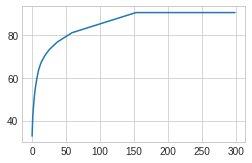

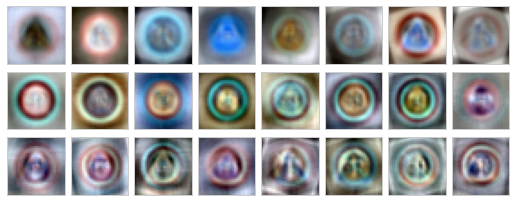

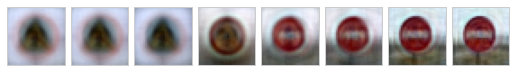

In [17]:
X_train_pca, X_test_pca, pca = run_pca(X_train_flattened, X_test_flattened)
visualize_pca(pca)
visualize_image_components(pca, X_train_flattened[1])

In the top graph we have a plot of variance explained against number of principal components used. We see a leveling off at around 150 principle components, which is what we end up choosing for our dimensionality reduction.

In the first 3 rows of the bottom image we see what the first 24 principle components evaluate to. 

In the last row we can see what happens when we project a test image on to the 0, 1, 2, 10, 30, 50, 100, 150 principle components

## Model
Now we will first take a look at the different CNN model architectures that we evaluated. There is no need to train a model on all of these, as it will take a long time.

**Please run the cell that includes CNN_Large()**

In [ ]:
# Xtra Small CNN
class CNN_XS(nn.Module):
    def __init__(self):
        super(CNN_XS, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 32, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.max_pool2d(x)
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [ ]:
# Small CNN
class CNN_S(nn.Module):
    def __init__(self):
        super(CNN_S, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(16 * 16 * 32, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [ ]:
# Medium sized CNN
class CNN_M(nn.Module):
    def __init__(self):
        super(CNN_M, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 64, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [20]:
# Large CNN
class CNN_L(nn.Module):
    def __init__(self):
        super(CNN_L, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.dropout_3 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_3(x)
        x = self.linear_2(x)
        return x

In [ ]:
# Large CNN without using any dropout
class CNN_L_NoDropout(nn.Module):
    def __init__(self):
        super(CNN_L_NoDropout, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [ ]:
# Large CNN without batch norm
class CNN_L_NoBatchNorm(nn.Module):
    def __init__(self):
        super(CNN_L_NoBatchNorm, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout_2 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.dropout_3 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.max_pool2d(x)

        x = self.relu(self.conv_3(x))
        x = self.relu(self.conv_4(x))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_3(x)
        x = self.linear_2(x)
        return x

In [ ]:
# Extra Large CNN
class CNN_XL(nn.Module):
    def __init__(self):
        super(CNN_XL, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(0.5)

        self.conv_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_7 = nn.BatchNorm2d(64)
        self.conv_8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_8 = nn.BatchNorm2d(64)
        self.dropout_3 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(2 * 2 * 64, 128)
        self.dropout_4 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)
        
        x = self.relu(self.batch_norm_7(self.conv_7(x)))
        x = self.relu(self.batch_norm_8(self.conv_8(x)))
        x = self.dropout_3(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_4(x)
        x = self.linear_2(x)
        return x

We also define methods that will be used to train and evaluate the CNN model

In [18]:
def load_torch_data(X_train, y_train, X_test, y_test):
    """Converts numpy data to torch dataloaders."""
    X_train, X_val, y_train, y_val = split_validation(X_train, y_train)
    train_set = data.TensorDataset(Tensor(X_train), Tensor(y_train))
    val_set = data.TensorDataset(Tensor(X_val), Tensor(y_val))
    test_set = data.TensorDataset(Tensor(X_test), Tensor(y_test))
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=32, shuffle=True)
    return train_loader, val_loader, test_loader
    

def train_model(model, train_loader, val_loader, epochs, lr):
    """Trains model and plots loss and accuracies."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) 

    losses = []
    train_accuracy, val_accuracy = [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_f1, val_f1 = [], []
    for epoch in range(epochs):
        running_loss = 0
        for itr, (image, label) in enumerate(train_loader):
            optimizer.zero_grad()
            y_predicted = model(image)
            label = label.long()

            loss = criterion(y_predicted, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
    
        losses.append(running_loss)
        _, (accuracy, precision, recall, f1) = evaluate_model(model, train_loader)
        train_accuracy.append(accuracy)
        train_precision.append(precision)
        train_recall.append(recall)
        train_f1.append(f1)
        _, (accuracy, precision, recall, f1) = evaluate_model(model, val_loader)
        val_accuracy.append(accuracy)
        val_precision.append(precision)
        val_recall.append(recall)
        val_f1.append(f1)
        print(f'Epoch: {epoch+1:03}, Loss: {running_loss:9.4f}, Train F1: {train_f1[-1]:.4f}, Validation F1: {val_f1[-1]:.4f}')

    fig, axs = plt.subplots(1, 5, figsize=(20, 2.5))
    axs[0].plot(losses)
    axs[1].plot(list(range(epochs)), train_accuracy, val_accuracy);
    axs[2].plot(list(range(epochs)), train_precision, val_precision);
    axs[3].plot(list(range(epochs)), train_recall, val_recall);
    axs[4].plot(list(range(epochs)), train_f1, val_f1);

    return model


def evaluate_model(model, dataloader):
    """Evaluates model and returns predictions, truth labels, and metrics."""
    accuracy, precision, recall, f1 = 0, 0, 0, 0

    preds = torch.Tensor([])
    labels = torch.Tensor([])
    with torch.no_grad():
        for _, (images, batch_labels) in enumerate(dataloader):
            outputs = model(images)
            _, batch_preds = torch.max(outputs.data, 1)
            preds = torch.cat((preds, batch_preds))
            labels = torch.cat((labels, batch_labels))
            batch_weight = images.size(0) / len(dataloader.dataset)
            accuracy += batch_weight * accuracy_score(batch_labels, batch_preds)
            precision += batch_weight * precision_score(batch_labels, batch_preds, average='macro', zero_division=0)
            recall += batch_weight * recall_score(batch_labels, batch_preds, average='macro', zero_division=0)
            f1 += batch_weight * f1_score(batch_labels, batch_preds, average='macro', zero_division=0)

    return (preds.tolist(), labels.tolist()), (accuracy, precision, recall, f1)

The cell below trains the CNN on our dataset. You may run this if you want to visualize the training and validation accuracy for the various epochs. However this takes a long time. You may also load the model and skip this cell

In [ ]:
print('========== Convolutional Neural Network ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_L(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

The cell below loads our model that is already trained

In [ ]:
model = CNN_L()
model.load_state_dict(torch.load('modelstate'))

## Evaluation

Define methods that will be used to evaluate the model

In [ ]:
def generate_confusion_matrix(y_actual, y_pred, labels):
    """Generates a confusion matrix for the given labels and predictions."""
    mat = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize = (30, 30))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = labels['Name'], yticklabels = labels['Name'])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
 
 
def get_classification_report(y_actual, y_pred, labels, print_df=False):
    """Reports evaluation metrics for the given labels and predictions."""
    report = classification_report(y_actual, y_pred, target_names = labels['Name'], output_dict = True, zero_division=0)
    mat = confusion_matrix(y_actual, y_pred)
    class_accuracies = mat.diagonal()/(mat.sum(axis = 1))
    for index, class_name in enumerate(labels['Name']):
        report[class_name]['accuracy'] = class_accuracies[index]

    df = pd.DataFrame.from_dict(report).T
    if print_df:
        print(tabulate(df, headers = ['Label', 'Precision', 'Recall', 'F1 Score', 'Support', 'Accuracy'], tablefmt = 'simple_grid'))

    metrics = ['macro avg', 'weighted avg']
    headers = list(report[metrics[0]].keys())
    table = [[metric] + list(report[metric].values()) for metric in metrics]
    print(f'accuracy: {report["accuracy"]}')
    print(tabulate(table, headers=headers, tablefmt='simple_grid'))

    return report, df


def generate_class_comparison(report, metric, labels):
    """Compares metrics for each class."""
    classes = list(labels['Name'])
    values = [report[cls][metric] for cls in classes]
    plt.xticks([], [])
    plt.bar(classes, values)
    plt.show()

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)